In [7]:
# Kütüphanelerin tanımlanması
import gymnasium as gym
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Ortamın içeri aktarılması
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)

In [15]:
# Eğitim
def train(env, num_episodes, learning_rate, discount_factor,
          initial_epsilon, min_epsilon, epsilon_decay_type,
          epsilon_decay_rate_or_value,
          max_steps_per_episode, q_table_initial_values="zeros", run_seed=None):

    if q_table_initial_values == "zeros":
        q_table = np.zeros((env.observation_space.n, env.action_space.n))
    elif q_table_initial_values == "random_small":
        q_table = np.random.rand(env.observation_space.n, env.action_space.n) * 0.01
    
    epsilon = initial_epsilon
    rewards_all_episodes = []
    expected_value_start_state = []

    start_time = time.time()

    initial_state_for_value_tracking = 0

    for episode in range(num_episodes):
        current_episode_seed = run_seed + episode if run_seed is not None else None
        state, _ = env.reset(seed=current_episode_seed)
        
        terminated = False
        truncated = False
        current_episode_reward = 0

        for step in range(max_steps_per_episode):
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            new_state, reward, terminated, truncated, _ = env.step(action)

            q_table[state, action] = q_table[state, action] + learning_rate * (
                reward + discount_factor * np.max(q_table[new_state, :]) - q_table[state, action]
            )

            current_episode_reward += reward
            state = new_state

            if terminated or truncated:
                break
        
        if epsilon_decay_type == 'linear':
            current_calculated_epsilon = initial_epsilon - (epsilon_decay_rate_or_value * episode)
            epsilon = max(min_epsilon, current_calculated_epsilon)
        elif epsilon_decay_type == 'exponential':
            epsilon = max(min_epsilon, epsilon * epsilon_decay_rate_or_value)
            
        rewards_all_episodes.append(current_episode_reward)
        expected_value_start_state.append(np.max(q_table[initial_state_for_value_tracking, :]))
        
    end_time = time.time()
    training_time = end_time - start_time
    
    return q_table, rewards_all_episodes, training_time, expected_value_start_state

In [17]:
# Test
def test(env, q_table, num_episodes, max_steps_per_episode):
    total_successes = 0
    episode_rewards = [] 

    for episode in range(num_episodes):
        test_episode_seed = np.random.randint(0, 10**7) 
        state, _ = env.reset(seed=test_episode_seed)
        terminated = False
        truncated = False
        current_episode_reward = 0
        
        for step in range(max_steps_per_episode):
            action = np.argmax(q_table[state, :])
            new_state, reward, terminated, truncated, _ = env.step(action)
            
            current_episode_reward += reward
            state = new_state

            if terminated or truncated:
                if reward == 1.0: 
                    total_successes += 1
                break
        episode_rewards.append(current_episode_reward)

    success_rate = total_successes / num_episodes
    average_reward = np.mean(episode_rewards) if episode_rewards else 0
    
    return success_rate, average_reward, episode_rewards

In [23]:
# --- Görselleştirme Fonksiyonları ---
def plot_learning_curve(rewards_all_runs, title="Öğrenme Eğrisi (Bölüm Başına Toplam Ödül)"):
    if not rewards_all_runs or not rewards_all_runs[0]:
        print(f"'{title}' için çizilecek veri yok.")
        return

    min_episodes = min(len(run_rewards) for run_rewards in rewards_all_runs)
    averaged_rewards = np.mean([run_rewards[:min_episodes] for run_rewards in rewards_all_runs], axis=0)
    
    window_size = 100 
    if len(averaged_rewards) >= window_size:
        smoothed_rewards = np.convolve(averaged_rewards, np.ones(window_size)/window_size, mode='valid')
        plot_range = range(window_size -1, len(averaged_rewards))
    else:
        smoothed_rewards = averaged_rewards
        plot_range = range(len(averaged_rewards))


    plt.figure(figsize=(12, 6))
    plt.plot(plot_range, smoothed_rewards)
    plt.title(title)
    plt.xlabel(f"Episode (Hareketli Ortalama Penceresi: {window_size if len(averaged_rewards) >= window_size else 1})")
    plt.ylabel("Ortalama Toplam Ödül")
    plt.grid(True)
    plt.show()
    print(f"'{title}' grafiğindeki plato/doyum noktası: Sonlara doğru eğrinin düzleştiği ve performansın önemli ölçüde artmadığı bölgedir. Bu, ajanın o anki hiperparametrelerle öğrenebileceğinin sınırına yaklaştığını gösterir.")


In [25]:
def plot_expected_value_curve(expected_values_all_runs, title="Başlangıç Durumu Beklenen Değer Eğrisi (V(s0))"):
    if not expected_values_all_runs or not expected_values_all_runs[0]:
        print(f"'{title}' için çizilecek veri yok.")
        return

    min_episodes = min(len(run_values) for run_values in expected_values_all_runs)
    averaged_values = np.mean([run_values[:min_episodes] for run_values in expected_values_all_runs], axis=0)
    
    window_size = 100
    if len(averaged_values) >= window_size:
        smoothed_values = np.convolve(averaged_values, np.ones(window_size)/window_size, mode='valid')
        plot_range = range(window_size -1, len(averaged_values))
    else:
        smoothed_values = averaged_values
        plot_range = range(len(averaged_values))


    plt.figure(figsize=(12, 6))
    plt.plot(plot_range, smoothed_values)
    plt.title(title)
    plt.xlabel(f"Episode (Hareketli Ortalama Penceresi: {window_size if len(averaged_values) >= window_size else 1})")
    plt.ylabel("Ortalama Beklenen Değer V(s0)")
    plt.grid(True)
    plt.show()

In [27]:
def plot_hyperparam_performance_bar(df, param_name, metric_name='mean_success_rate', error_name='std_dev_success_rate', title_prefix=""):
    if df.empty:
        print(f"Çubuk grafik için veri yok: {param_name}")
        return

    df_copy = df.copy()
    df_copy[param_name] = df_copy[param_name].astype(str)
    
    try:
        if param_name == 'epsilon_strategy': 
             grouped_data = df_copy.groupby(param_name)[[metric_name, error_name]].agg(['mean', 'std'])
             metric_plot = grouped_data[metric_name]['mean']
             error_plot = grouped_data[error_name]['mean']
             error_plot = df_copy.groupby(param_name)[error_name].mean()
        else:
            grouped_data = df_copy.groupby(param_name)[[metric_name, error_name]].mean()
            metric_plot = grouped_data[metric_name]
            error_plot = grouped_data[error_name]


        plt.figure(figsize=(12, 7))
        bars = metric_plot.plot(kind='bar', yerr=error_plot, capsize=5, color=sns.color_palette("viridis", len(metric_plot)))
        
        plt.title(f"{title_prefix}{param_name} vs {metric_name.replace('_', ' ').title()}", fontsize=15)
        plt.xlabel(str(param_name).replace('_', ' ').title(), fontsize=12)
        plt.ylabel(metric_name.replace('_', ' ').title(), fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"Hata: '{e}' sütunu DataFrame'de bulunamadı. Param_name doğru mu?")
    except Exception as e:
        print(f"Çubuk grafik çizilirken bir hata oluştu ({param_name}): {e}")

In [29]:
def plot_hyperparam_performance_boxplot(df, param_name, data_column_name='run_success_rates_all', title_prefix=""):
    if df.empty or data_column_name not in df.columns:
        print(f"Kutu grafik için veri yok: {param_name} / {data_column_name}")
        return

    plot_data = []
    df[param_name] = df[param_name].astype(str)

    for _, row in df.iterrows():
        param_value = row[param_name]
        if isinstance(row[data_column_name], list):
            for success_rate_value in row[data_column_name]:
                plot_data.append({param_name: param_value, 'success_rate': success_rate_value})
        else:
            pass

    if not plot_data:
        print(f"Boxplot için {param_name} parametresine göre işlenecek veri bulunamadı.")
        return
        
    plot_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 8))
    sns.boxplot(x=param_name, y='success_rate', data=plot_df, palette="viridis")
    plt.title(f"{title_prefix}{str(param_name).replace('_', ' ').title()} vs Başarı Oranı Dağılımı", fontsize=16)
    plt.xlabel(str(param_name).replace('_', ' ').title(), fontsize=13)
    plt.ylabel("Başarı Oranı (Tek Çalıştırma)", fontsize=13)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [37]:
# Parametre tanımlaması
param_grid = {
    'learning_rate': [0.05, 0.1], 
    'discount_factor': [0.99], 
    'initial_epsilon': [1.0],
    'min_epsilon': [0.1], 
    'epsilon_decay_type': ['linear', 'exponential', 'constant'],
    'epsilon_decay_params': { 
        'linear_decay_portion': [0.9], 
        'exponential': [0.999, 0.9995], 
        'constant': [0.1] 
    },
    'num_train_episodes': [10000, 20000],
    'q_table_initial_values': ['zeros', 'random_small'] 
}

num_test_episodes_global = 1000
max_steps_per_episode_global = 250 
num_runs_per_combination = 5


--- Deney 1 Başlıyor ---
Parametreler: LR=0.05, Gamma=0.99, TrainEPS=10000, Q_init=zeros
Epsilon Stratejisi: Type=linear, Init=1.0, Min=0.1, DecayVal/Rate/Const=0.00010
Linear Epsilon Decay Portion: 0.9
  Çalıştırma 1/5 (Seed: 1748774375)
  Çalıştırma 2/5 (Seed: 1748774397)
  Çalıştırma 3/5 (Seed: 1748774407)
  Çalıştırma 4/5 (Seed: 1748774417)
  Çalıştırma 5/5 (Seed: 1748774428)
Sonuçlar: Ort. Başarı: 0.534 (StdDev: 0.028), Ort. Ödül: 0.534 (StdDev: 0.028)

--- Deney 2 Başlıyor ---
Parametreler: LR=0.05, Gamma=0.99, TrainEPS=10000, Q_init=zeros
Epsilon Stratejisi: Type=exponential, Init=1.0, Min=0.1, DecayVal/Rate/Const=0.99900
  Çalıştırma 1/5 (Seed: 1748774433)
  Çalıştırma 2/5 (Seed: 1748774446)
  Çalıştırma 3/5 (Seed: 1748774459)
  Çalıştırma 4/5 (Seed: 1748774472)
  Çalıştırma 5/5 (Seed: 1748774485)
Sonuçlar: Ort. Başarı: 0.000 (StdDev: 0.000), Ort. Ödül: 0.000 (StdDev: 0.000)

--- Deney 3 Başlıyor ---
Parametreler: LR=0.05, Gamma=0.99, TrainEPS=10000, Q_init=zeros
Epsilon Strat

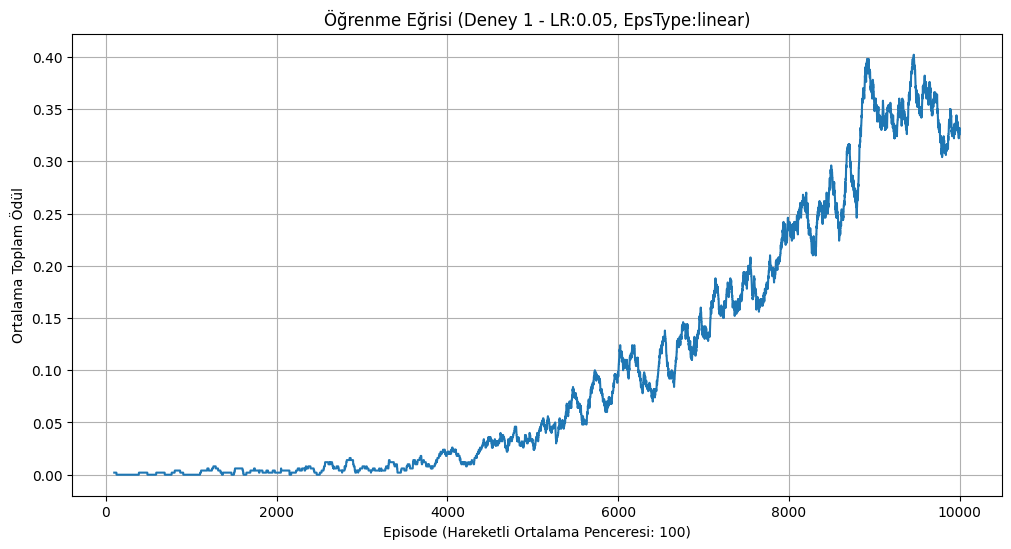

'Öğrenme Eğrisi (Deney 1 - LR:0.05, EpsType:linear)' grafiğindeki plato/doyum noktası: Sonlara doğru eğrinin düzleştiği ve performansın önemli ölçüde artmadığı bölgedir. Bu, ajanın o anki hiperparametrelerle öğrenebileceğinin sınırına yaklaştığını gösterir.


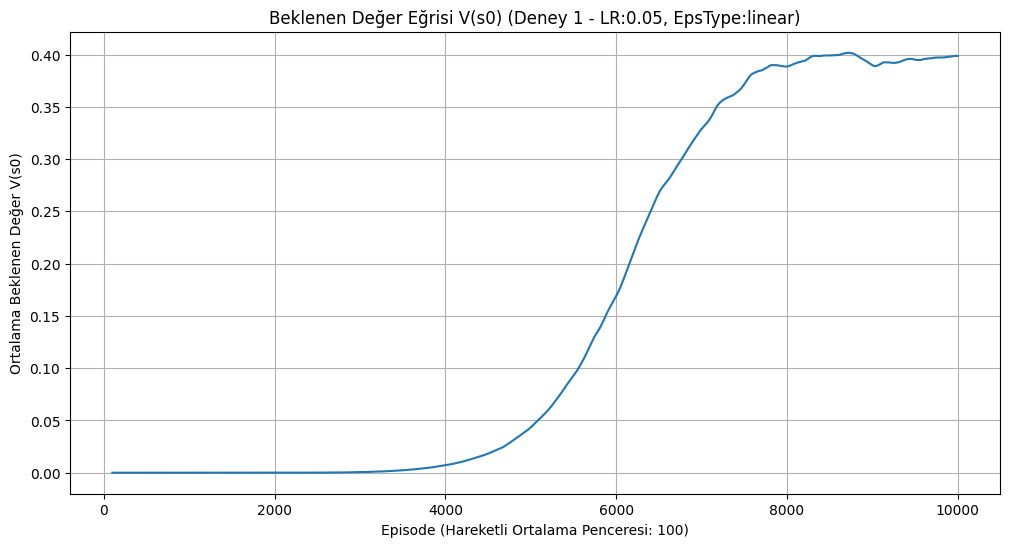

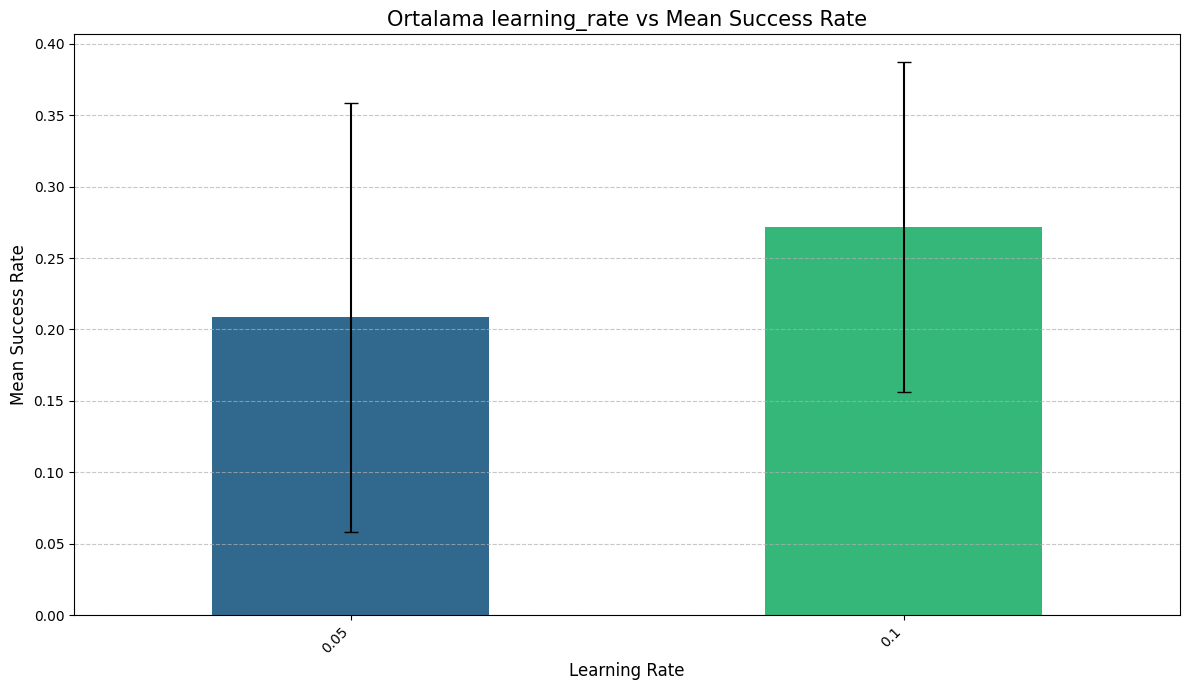

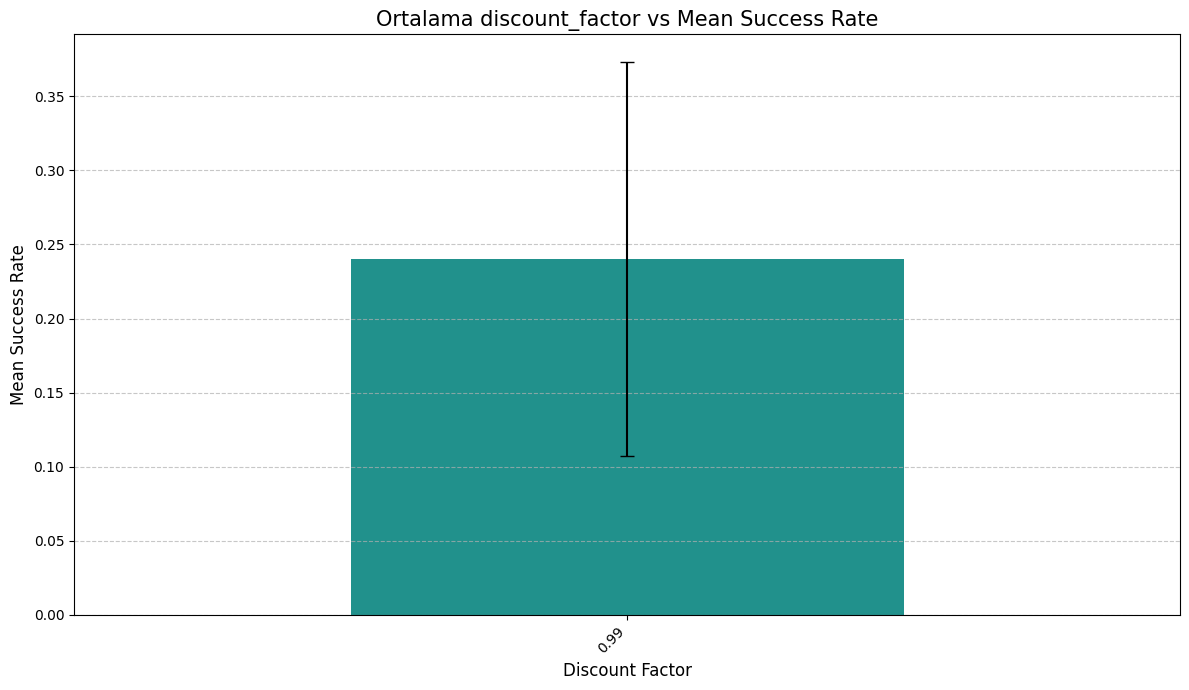

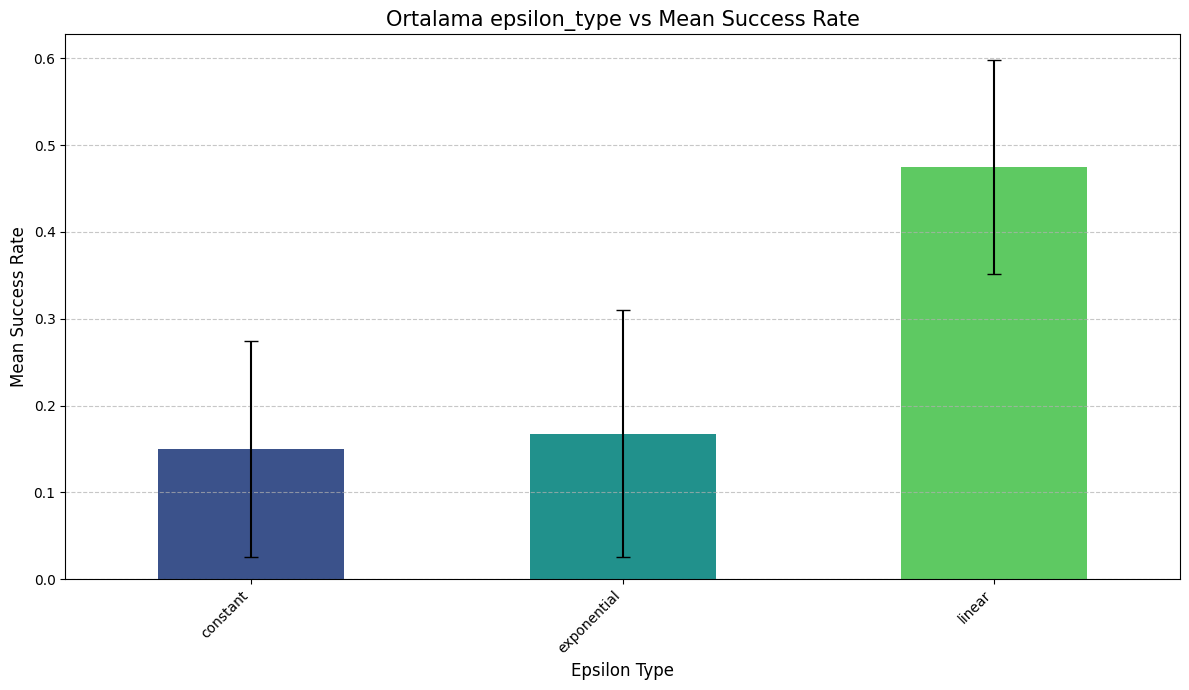

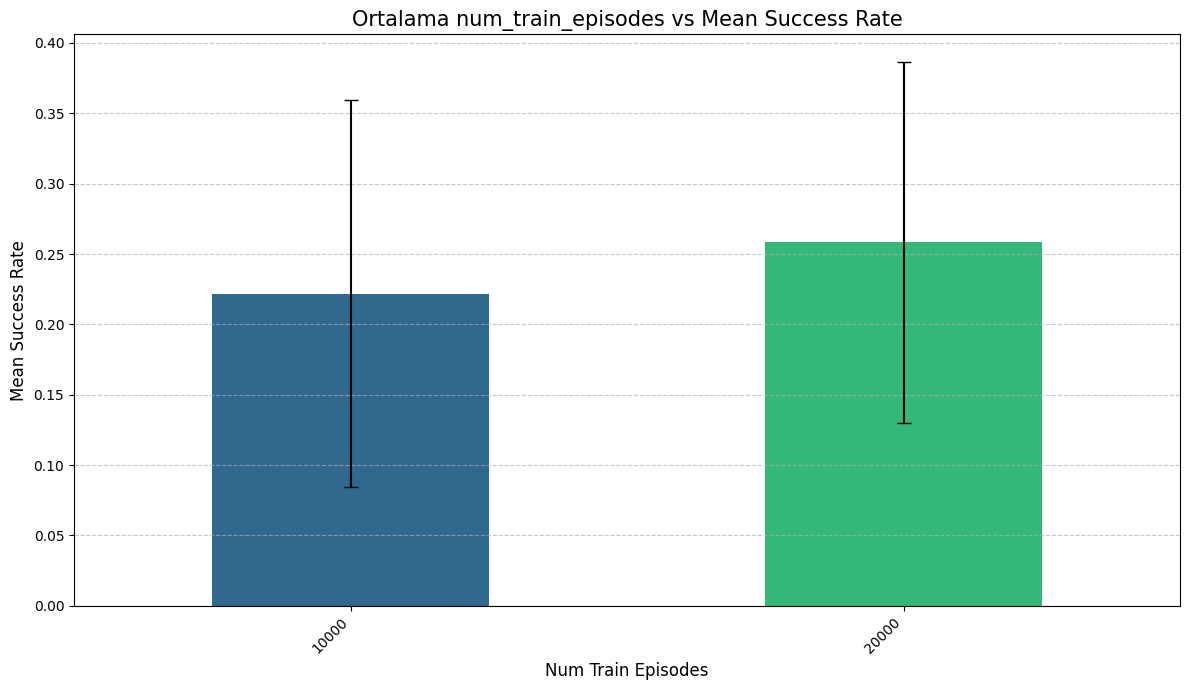

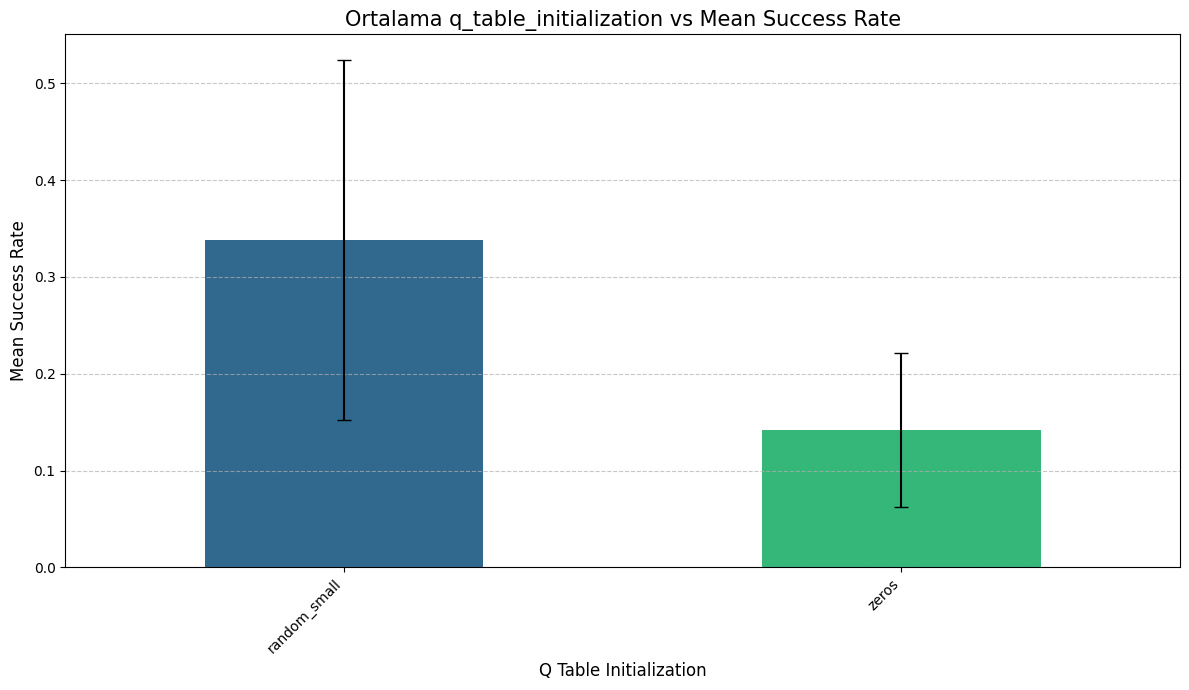

C:\Users\SD\AppData\Local\Temp\ipykernel_13124\3915861922.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=param_name, y='success_rate', data=plot_df, palette="viridis")


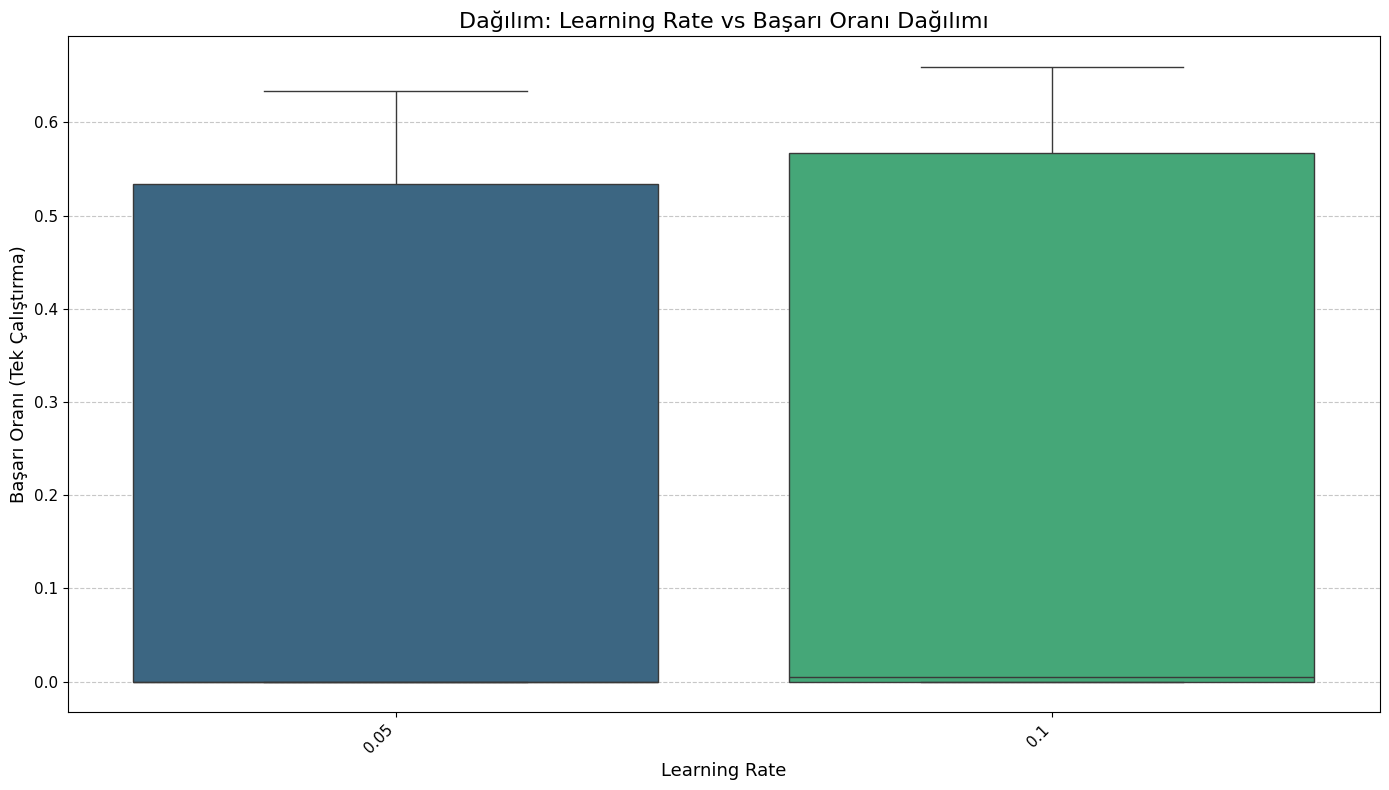

C:\Users\SD\AppData\Local\Temp\ipykernel_13124\3915861922.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=param_name, y='success_rate', data=plot_df, palette="viridis")


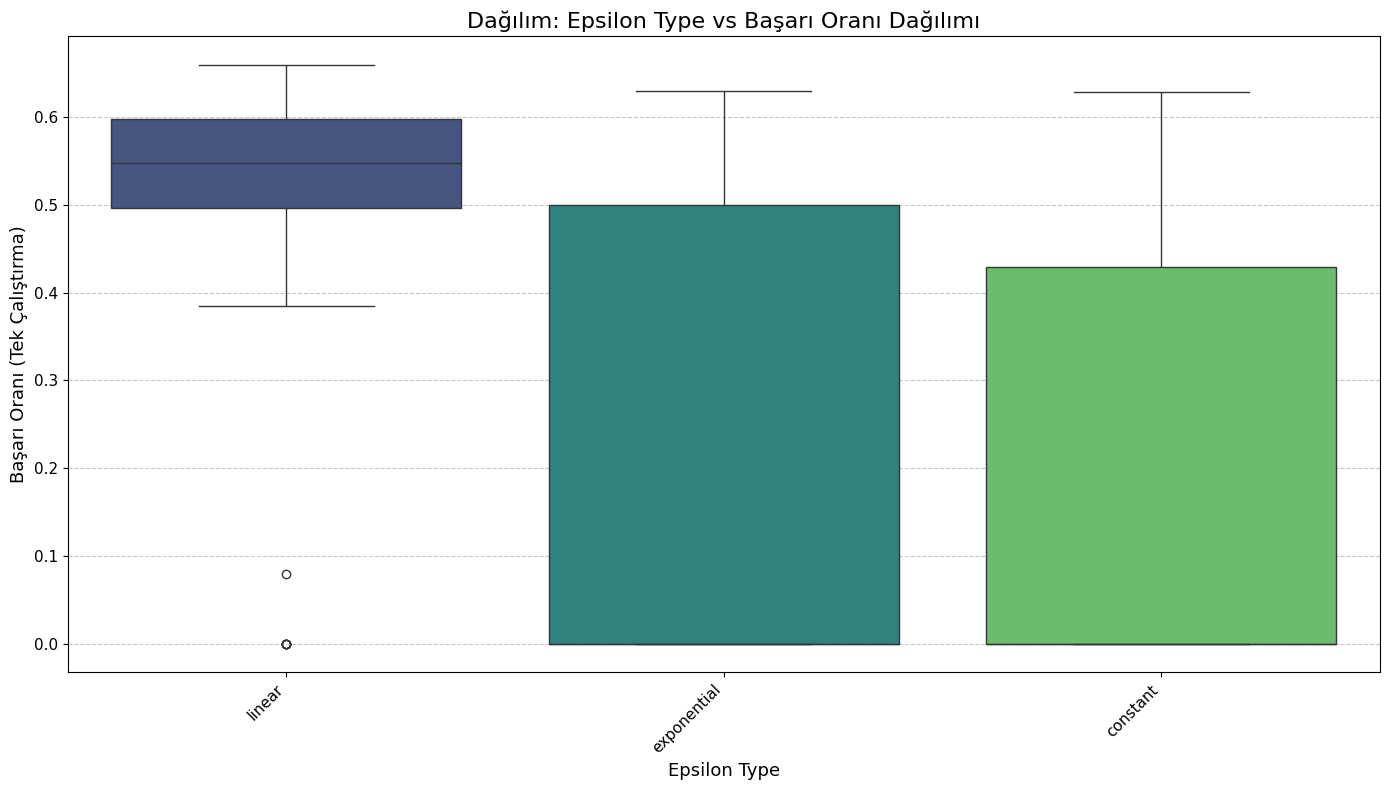

C:\Users\SD\AppData\Local\Temp\ipykernel_13124\3915861922.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=param_name, y='success_rate', data=plot_df, palette="viridis")


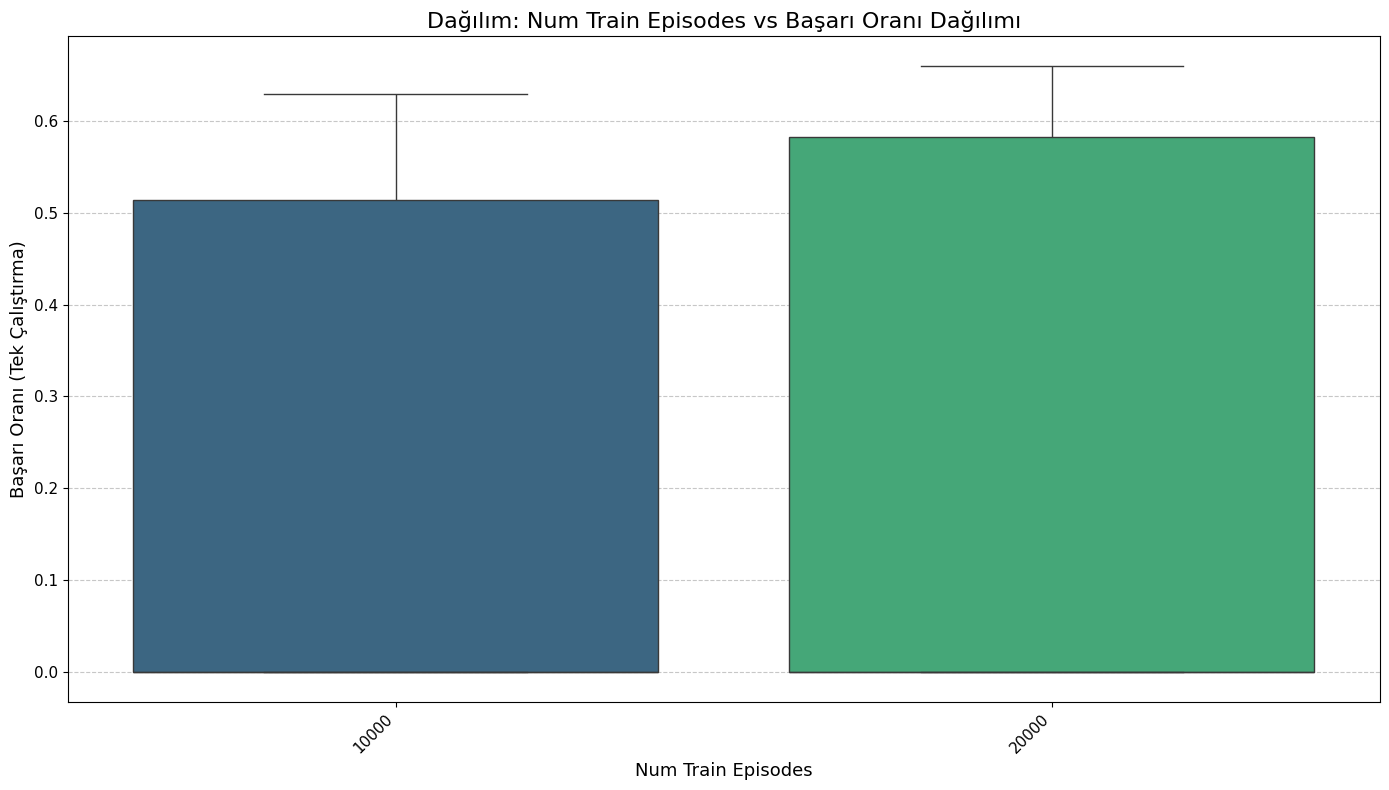

In [39]:
results_list = [] 

experiment_counter = 0
for lr in param_grid['learning_rate']:
    for df_gamma in param_grid['discount_factor']:
        for num_train_eps in param_grid['num_train_episodes']:
            for init_eps in param_grid['initial_epsilon']:
                for min_eps in param_grid['min_epsilon']:
                    for q_init in param_grid['q_table_initial_values']:
                        for eps_type in param_grid['epsilon_decay_type']:
                            
                            current_eps_specific_params = []
                            if eps_type == 'linear':
                                for decay_portion in param_grid['epsilon_decay_params']['linear_decay_portion']:
                                    denominator = num_train_eps * decay_portion
                                    if denominator <=0:
                                        decay_val = (init_eps - min_eps) / num_train_eps if num_train_eps > 0 else 0.0001
                                    else:
                                        decay_val = (init_eps - min_eps) / denominator
                                    current_eps_specific_params.append({'val': decay_val, 'portion': decay_portion})
                            elif eps_type == 'exponential':
                                for exp_rate in param_grid['epsilon_decay_params']['exponential']:
                                    current_eps_specific_params.append({'val': exp_rate})
                            elif eps_type == 'constant':
                                for const_val in param_grid['epsilon_decay_params']['constant']:
                                    current_eps_specific_params.append({'val': const_val})

                            for eps_param_pack in current_eps_specific_params:
                                eps_decay_param_val = eps_param_pack['val']
                                experiment_counter += 1
                                print(f"\n--- Deney {experiment_counter} Başlıyor ---")
                                print(f"Parametreler: LR={lr}, Gamma={df_gamma}, TrainEPS={num_train_eps}, Q_init={q_init}")
                                print(f"Epsilon Stratejisi: Type={eps_type}, Init={init_eps}, Min={min_eps}, DecayVal/Rate/Const={eps_decay_param_val:.5f}")
                                if eps_type == 'linear':
                                    print(f"Linear Epsilon Decay Portion: {eps_param_pack.get('portion', 'N/A')}")

                                run_success_rates_for_boxplot = []
                                run_average_rewards_for_boxplot = []
                                run_training_times = []
                                all_train_rewards_one_combination = [] 
                                all_expected_values_one_combination = []

                                for run_idx in range(num_runs_per_combination):
                                    current_seed_for_run = int(time.time()) + run_idx + experiment_counter 
                                    np.random.seed(current_seed_for_run) 
                                    
                                    print(f"  Çalıştırma {run_idx+1}/{num_runs_per_combination} (Seed: {current_seed_for_run})")
                                    
                                    current_initial_epsilon_for_train = init_eps
                                    current_min_epsilon_for_train = min_eps
                                    
                                    train_call_eps_decay_type = eps_type
                                    train_call_eps_decay_val = eps_decay_param_val

                                    if eps_type == 'constant':
                                        current_initial_epsilon_for_train = eps_decay_param_val
                                        current_min_epsilon_for_train = eps_decay_param_val
                                        train_call_eps_decay_type = 'linear' 
                                        train_call_eps_decay_val = 0

                                    q_table, train_rewards_per_episode, training_time, expected_values_per_episode = train(
                                        env, num_train_eps, lr, df_gamma,
                                        current_initial_epsilon_for_train, current_min_epsilon_for_train,
                                        train_call_eps_decay_type,
                                        train_call_eps_decay_val,
                                        max_steps_per_episode_global,
                                        q_table_initial_values=q_init,
                                        run_seed=current_seed_for_run
                                    )
                                    
                                    all_train_rewards_one_combination.append(train_rewards_per_episode)
                                    all_expected_values_one_combination.append(expected_values_per_episode)
                                    
                                    success_rate, average_reward, _ = test(env, q_table, num_test_episodes_global, max_steps_per_episode_global)
                                    
                                    run_success_rates_for_boxplot.append(success_rate)
                                    run_average_rewards_for_boxplot.append(average_reward)
                                    run_training_times.append(training_time)
                                
                                mean_success_rate = np.mean(run_success_rates_for_boxplot)
                                std_success_rate = np.std(run_success_rates_for_boxplot)
                                var_success_rate = np.var(run_success_rates_for_boxplot)

                                mean_avg_reward = np.mean(run_average_rewards_for_boxplot)
                                std_avg_reward = np.std(run_average_rewards_for_boxplot)
                                
                                mean_training_time = np.mean(run_training_times)

                                eps_param_detail = f"{eps_decay_param_val:.5f}"
                                if eps_type == 'linear':
                                    eps_param_detail += f" (portion:{eps_param_pack.get('portion', 'N/A')})"

                                results_list.append({
                                    'learning_rate': lr,
                                    'discount_factor': df_gamma,
                                    'num_train_episodes': num_train_eps,
                                    'q_table_initialization': q_init,
                                    'epsilon_type': eps_type,
                                    'initial_epsilon': init_eps, 
                                    'min_epsilon': min_eps,     
                                    'epsilon_param_value_detail': eps_param_detail, 
                                    'epsilon_param_numeric': eps_decay_param_val, 
                                    'mean_success_rate': mean_success_rate,
                                    'std_dev_success_rate': std_success_rate,
                                    'variance_success_rate': var_success_rate,
                                    'mean_average_reward_on_test': mean_avg_reward,
                                    'std_dev_average_reward_on_test': std_avg_reward,
                                    'mean_training_time': mean_training_time,
                                    'train_rewards_all_runs': all_train_rewards_one_combination, 
                                    'run_success_rates_all': run_success_rates_for_boxplot,
                                    'expected_values_all_runs': all_expected_values_one_combination 
                                })
                                
                                print(f"Sonuçlar: Ort. Başarı: {mean_success_rate:.3f} (StdDev: {std_success_rate:.3f}), Ort. Ödül: {mean_avg_reward:.3f} (StdDev: {std_avg_reward:.3f})")

results_df = pd.DataFrame(results_list)
print("\n--- Tüm Deney Sonuçları (DataFrame) ---")
if not results_df.empty:
    print(results_df.head())
    results_df.to_csv("q_learning_frozen_lake_8x8_experiment_results_full.csv", index=False)
    print("\nDeney sonuçları 'q_learning_frozen_lake_8x8_experiment_results_full.csv' dosyasına kaydedildi.")
else:
    print("Hiçbir deney sonucu üretilmedi.")
    
if not results_df.empty:
    print("\n--- Görselleştirmeler Oluşturuluyor ---")
    
    if 'train_rewards_all_runs' in results_df.columns and results_df.iloc[0]['train_rewards_all_runs']:
        plot_learning_curve(results_df.iloc[0]['train_rewards_all_runs'], 
                            title=f"Öğrenme Eğrisi (Deney 1 - LR:{results_df.iloc[0]['learning_rate']}, EpsType:{results_df.iloc[0]['epsilon_type']})")
    else:
        print("İlk deney için öğrenme eğrisi verisi bulunamadı.")

    if 'expected_values_all_runs' in results_df.columns and results_df.iloc[0]['expected_values_all_runs']:
        plot_expected_value_curve(results_df.iloc[0]['expected_values_all_runs'],
                                 title=f"Beklenen Değer Eğrisi V(s0) (Deney 1 - LR:{results_df.iloc[0]['learning_rate']}, EpsType:{results_df.iloc[0]['epsilon_type']})")
    else:
        print("İlk deney için beklenen değer eğrisi verisi bulunamadı.")
    
    plot_hyperparam_performance_bar(results_df, 'learning_rate', title_prefix="Ortalama ")
    plot_hyperparam_performance_bar(results_df, 'discount_factor', title_prefix="Ortalama ")
    plot_hyperparam_performance_bar(results_df, 'epsilon_type', title_prefix="Ortalama ")
    plot_hyperparam_performance_bar(results_df, 'num_train_episodes', title_prefix="Ortalama ")
    plot_hyperparam_performance_bar(results_df, 'q_table_initialization', title_prefix="Ortalama ")


    if 'run_success_rates_all' in results_df.columns:
         plot_hyperparam_performance_boxplot(results_df, 'learning_rate', 
                                            data_column_name='run_success_rates_all', 
                                            title_prefix="Dağılım: ")
         plot_hyperparam_performance_boxplot(results_df, 'epsilon_type',
                                            data_column_name='run_success_rates_all',
                                            title_prefix="Dağılım: ")
         plot_hyperparam_performance_boxplot(results_df, 'num_train_episodes',
                                            data_column_name='run_success_rates_all',
                                            title_prefix="Dağılım: ")
    else:
        print("Kutu grafikleri için 'run_success_rates_all' sütunu bulunamadı.")

else:
    print("Görselleştirilecek deney sonucu bulunamadı.")

env.close()